# **ĐỒ ÁN XỬ LÝ ẢNH - PHÁT HIỆN QR-CODE**
> Nhóm 7

### **Imports & Thư viện**

In [1]:
import os
import cv2
import glob
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

plt.rcParams['figure.figsize'] = (10, 10)
print("Libraries imported successfully!")

Libraries imported successfully!


### **Cấu hình Đường dẫn (Config)**

In [23]:
PATH_DATASET = "./train/finderPatterns"            # Folder train
INPUT_DIR = 'QRCode'                                 # Folder test batch
OUTPUT_DIR = 'output_qr'                             # Folder lưu kết quả
os.makedirs(OUTPUT_DIR, exist_ok=True)

### **Định nghĩa Class Model (PCA Classifier)**

In [12]:
import cv2
import numpy as np
import os

class QR_PCA_Classifier:
    def __init__(self, input_dim=400, n_components=10):
        self.mean = None
        self.eigenvectors = None
        self.n_components = n_components 
        self.ideal_coeffs = None
        self.threshold = 0

    def train_from_yolo(self, dataset_folder):
        """
        Huấn luyện PCA từ bộ dữ liệu YOLO (Ảnh to + File Label).
        Tự động cắt Finder Pattern ra để học.
        """
        images_path = os.path.join(dataset_folder, "images")
        labels_path = os.path.join(dataset_folder, "labels")

        if not os.path.exists(images_path) or not os.path.exists(labels_path):
            print("Lỗi: Không tìm thấy thư mục 'images' hoặc 'labels'. Kiểm tra lại đường dẫn!")
            return

        print(f"Đang xử lý dữ liệu từ: {dataset_folder}...")
        train_data = []
        count_crops = 0

        valid_extensions = ('.jpg', '.png', '.jpeg')
        
        # Duyệt qua tất cả các file ảnh
        for filename in os.listdir(images_path):
            if filename.lower().endswith(valid_extensions):
                # 1. Đọc ảnh gốc
                img_full_path = os.path.join(images_path, filename)
                img = cv2.imread(img_full_path, cv2.IMREAD_GRAYSCALE)
                
                if img is None: continue
                
                height, width = img.shape

                # 2. Tìm file label tương ứng
                # Giả sử ảnh là 'qr_01.png' thì label là 'qr_01.txt'
                label_name = os.path.splitext(filename)[0] + ".txt"
                label_full_path = os.path.join(labels_path, label_name)

                if os.path.exists(label_full_path):
                    with open(label_full_path, 'r') as f:
                        lines = f.readlines()
                        
                        for line in lines:
                            # Định dạng YOLO: class x_center y_center w h (tất cả là tỉ lệ 0-1)
                            parts = line.strip().split()
                            if len(parts) >= 5:
                                # Lấy tọa độ
                                x_center, y_center = float(parts[1]), float(parts[2])
                                w_rel, h_rel = float(parts[3]), float(parts[4])

                                # Chuyển đổi từ tỉ lệ sang pixel thật
                                w_px = int(w_rel * width)
                                h_px = int(h_rel * height)
                                x_px = int((x_center * width) - (w_px / 2))
                                y_px = int((y_center * height) - (h_px / 2))

                                # Xử lý biên (để không bị lỗi cắt ra ngoài ảnh)
                                x_px = max(0, x_px)
                                y_px = max(0, y_px)
                                x_end = min(width, x_px + w_px)
                                y_end = min(height, y_px + h_px)

                                # 3. CẮT ẢNH (CROP)
                                crop_img = img[y_px:y_end, x_px:x_end]

                                # Kiểm tra ảnh cắt có hợp lệ không
                                if crop_img.size > 0 and crop_img.shape[0] > 5 and crop_img.shape[1] > 5:
                                    # 4. Resize về 20x20 chuẩn để train
                                    img_resized = cv2.resize(crop_img, (20, 20), interpolation=cv2.INTER_AREA)
                                    _, img_bin = cv2.threshold(img_resized, 127, 255, cv2.THRESH_BINARY)
                                    
                                    train_data.append(img_bin.flatten())
                                    count_crops += 1

        # --- Phần tính toán PCA giữ nguyên ---
        if len(train_data) == 0:
            print("Lỗi: Không cắt được mẫu nào! Kiểm tra lại file label.")
            return

        train_data = np.array(train_data, dtype=np.float32)
        print(f"-> Đã cắt thành công {count_crops} mẫu Finder Pattern từ ảnh to.")
        
        self.mean, self.eigenvectors = cv2.PCACompute(
            train_data, mean=None, maxComponents=self.n_components
        )
        
        projected_train = cv2.PCAProject(train_data, self.mean, self.eigenvectors)
        self.ideal_coeffs = np.mean(projected_train, axis=0)
        dists = [np.linalg.norm(v - self.ideal_coeffs) for v in projected_train]
        self.threshold = np.mean(dists) + 3 * np.std(dists)

        print(f"Huấn luyện xong. Ngưỡng T_D = {self.threshold:.2f}")

    # Giữ nguyên hàm predict cũ của bạn
    def predict(self, img_20x20):
        if img_20x20.shape != (20, 20):
            img_20x20 = cv2.resize(img_20x20, (20, 20))
        vec = img_20x20.flatten().astype(np.float32).reshape(1, -1)
        coeffs = cv2.PCAProject(vec, self.mean, self.eigenvectors)
        dist = np.linalg.norm(coeffs - self.ideal_coeffs)
        return dist <= self.threshold, dist



### **Thực thi Huấn luyện**

In [17]:
# CHẠY Training PCA TỪ DỮ LIỆU YOLO
print("BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH PCA TỪ DỮ LIỆU YOLO ")
pca_model = QR_PCA_Classifier()
pca_model.train_from_yolo(PATH_DATASET)

BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH PCA TỪ DỮ LIỆU YOLO 
Đang xử lý dữ liệu từ: ./train/finderPatterns...
-> Đã cắt thành công 6286 mẫu Finder Pattern từ ảnh to.
Huấn luyện xong. Ngưỡng T_D = 3180.75


### **Các hàm Tiền xử lý (Step 1 & Step 2)**

In [6]:
def step1_preprocessing_refined(image_path):
    # 1. Đọc ảnh
    original_img = cv2.imread(image_path)
    if original_img is None:
        return None, None

    # 2. Chuyển sang Grayscale
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

    median_blurred = cv2.medianBlur(gray_img, 3)

    # 3. Phân ngưỡng thích nghi (Adaptive Threshold)
    binary_img = cv2.adaptiveThreshold(
        median_blurred,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=61,
        C=1,
    )

    # 4. Morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # 5. Dùng Close để lấp các lỗ trắng nhỏ li ti bên trong khối đen
    morph_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

    return morph_img, {
        "Original": original_img,
        "Grayscale": gray_img,
        "Adaptive Threshold (Fixed)": binary_img,
        "Morphology": morph_img,
    }

def step2_extract_candidates_pca_friendly(binary_img, original_gray):
    """
    STEP 2 (Refactor):
    - Không dùng boundingRect
    - Không check ratio 1:1:3:1:1 thủ công
    - Chuẩn hóa mọi contour về ROI 20x20 bằng minAreaRect
    - Phù hợp cho PCA (chịu xoay, méo)
    """

    contours, hierarchy = cv2.findContours(
        binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )
    if hierarchy is None:
        return [], [], binary_img
    hierarchy = hierarchy[0]
    candidates = []
    locs = []
    debug_img = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)

    H, W = binary_img.shape

    for i, cnt in enumerate(contours):

        # 1. Kiểm tra có cấu trúc lồng (FP có ít nhất 2 level con)
        child = hierarchy[i][2]
        if child == -1:
            continue
        grandchild = hierarchy[child][2]
        if grandchild == -1:
            continue

        # 2. Diện tích contour (lọc nhiễu)
        area = cv2.contourArea(cnt)
        if area < 200 or area > 0.4 * H * W:
            continue

        # 3. MinAreaRect (xoay tự do)
        rect = cv2.minAreaRect(cnt)
        (cx, cy), (rw, rh), angle = rect
        if rw < 10 or rh < 10:
            continue

        # Cho phép FP bị méo nhưng không quá dẹt
        ratio = max(rw, rh) / (min(rw, rh) + 1e-6)
        if ratio > 2.5:
            continue

        # 4. Lấy 4 đỉnh của rect
        box = cv2.boxPoints(rect)
        box = np.int32(box)

        # 5. Warp affine → chuẩn hóa về 20x20
        dst_pts = np.array([[0, 0], [19, 0], [19, 19], [0, 19]], dtype=np.float32)
        src_pts = box.astype(np.float32)
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        roi_warp = cv2.warpPerspective(original_gray, M, (20, 20), borderValue=255)

        # 6. Nhị phân nhẹ lại (giúp PCA ổn định)
        roi_norm = roi_warp.astype(np.float32) / 255.0
        candidates.append(roi_norm)

        # Lưu bbox để vẽ
        locs.append(box)

        # Debug
        cv2.drawContours(debug_img, [box], 0, (0, 255, 0), 2)

    print(f"[STEP 2] Tìm thấy {len(candidates)} ứng viên (xoay + méo OK)")
    return candidates, locs, debug_img

### **Các hàm Lọc và Gom nhóm (Step 3 & Step 4)**

In [7]:
def step3_pca_filter(candidates, locs, pca_model, debug_img_shape):
    """
    Lọc danh sách ứng viên từ Bước 2 qua bộ lọc PCA
    """
    final_fps = []  # Chứa các FP thật
    final_locs = []  # Tọa độ FP thật

    debug_img = np.zeros((debug_img_shape[0], debug_img_shape[1], 3), dtype=np.uint8)

    print(f"\n BẮT ĐẦU BƯỚC 3: KIỂM TRA {len(candidates)} ỨNG VIÊN ")

    for i, roi in enumerate(candidates):
        # Dự đoán
        is_real, dist = pca_model.predict(roi)
        box = locs[i]
        x, y, w, h = cv2.boundingRect(box)

        if is_real:
            print(f"Ứng viên {i}: THẬT (Dist: {dist:.2f} <= {pca_model.threshold:.2f})")
            final_fps.append(roi)
            final_locs.append(locs[i])

            # Vẽ màu XANH LÁ cho mẫu thật
            cv2.rectangle(debug_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(
                debug_img,
                f"{dist:.1f}",
                (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                1,
            )
        else:
            # Vẽ màu ĐỎ cho mẫu giả
            cv2.rectangle(debug_img, (x, y), (x + w, y + h), (0, 0, 255), 1)

    print(f"Kết quả: Giữ lại {len(final_fps)}/{len(candidates)} ứng viên.")
    return final_fps, final_locs, debug_img

def get_center_point(box):
    """Lấy tâm của bounding box"""
    return tuple(np.mean(box, axis=0).astype(int)) if len(box) == 4 else None

def validate_L_shape(p1, p2, p3):
    """
    Kiểm tra 3 điểm tạo thành hình L (tam giác vuông cân)
    Returns: (is_valid, corner_idx, quality_score)
    """
    points = [p1, p2, p3]

    # Tính 3 cạnh
    d12 = np.linalg.norm(np.array(p1) - np.array(p2))
    d23 = np.linalg.norm(np.array(p2) - np.array(p3))
    d13 = np.linalg.norm(np.array(p1) - np.array(p3))

    # Sắp xếp: [ngắn, trung, dài (huyền)]
    sides = sorted([(d12, 0, 1), (d23, 1, 2), (d13, 0, 2)])
    a, b, c = sides[0][0], sides[1][0], sides[2][0]

    # Tìm góc vuông (điểm không thuộc cạnh huyền)
    corner_idx = list({0, 1, 2} - {sides[2][1], sides[2][2]})[0]

    # Validation
    pythagoras_err = abs(a**2 + b**2 - c**2) / (c**2 + 1e-6)
    ratio = b / (a + 1e-6)

    if pythagoras_err > 0.45 or ratio > 2.0:
        return False, -1, 0

    # Kiểm tra góc
    other = [points[i] for i in range(3) if i != corner_idx]
    v1 = np.array(other[0]) - np.array(points[corner_idx])
    v2 = np.array(other[1]) - np.array(points[corner_idx])
    angle = np.degrees(np.arccos(np.clip(np.dot(v1, v2) /
                      (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6), -1, 1)))

    if abs(angle - 90) > 45:
        return False, -1, 0

    # Điểm chất lượng
    quality = (100 * (1 - pythagoras_err) * 0.4 +
               100 * (1.5 - (ratio - 1)) / 0.5 * 0.3 +
               (100 - abs(angle - 90) * 2) * 0.3)

    return True, corner_idx, quality

def step4_grouping_and_bbox(real_fps, real_locs, original_img):
    """STEP 4: Phát hiện QR code từ Finder Patterns"""

    if len(real_fps) < 3:
        print(f"[STEP 4] Không đủ FP (cần ≥3, có {len(real_fps)})")
        return original_img.copy(), []

    print(f"\n{'='*60}\nBƯỚC 4: PHÂN TÍCH {len(real_fps)} FINDER PATTERNS\n{'='*60}")

    centers = [get_center_point(loc) for loc in real_locs]
    candidates = []

    # Tìm tất cả tổ hợp hợp lệ
    for i, j, k in combinations(range(len(centers)), 3):
        is_valid, corner_idx, quality = validate_L_shape(centers[i], centers[j], centers[k])

        if not is_valid:
            continue

        points = [centers[i], centers[j], centers[k]]
        corner = points[corner_idx]
        others = [points[x] for x in range(3) if x != corner_idx]

        # Kiểm tra kích thước
        avg_side = np.mean([np.linalg.norm(np.array(corner) - np.array(p)) for p in others])
        img_diag = np.sqrt(original_img.shape[0]**2 + original_img.shape[1]**2)

        if avg_side < 60 or avg_side > img_diag * 0.7:
            continue

        # Tạo bbox hình vuông
        v1 = np.array(others[0]) - np.array(corner)
        v2 = np.array(others[1]) - np.array(corner)
        fourth = np.array(corner) + v1 + v2

        bbox = np.array([corner, others[0], fourth, others[1]], dtype=np.float32)
        center_box = np.mean(bbox, axis=0)
        bbox = np.int32(center_box + (bbox - center_box) * 1.60)  # Mở rộng 45%

        candidates.append({
            'fps': [i, j, k],
            'centers': points,
            'corner': [i, j, k][corner_idx],
            'bbox': bbox,
            'quality': quality
        })

        print(f"✓ FP[{i},{j},{k}] - Góc:FP{[i,j,k][corner_idx]} - Q:{quality:.0f}")

    if not candidates:
        print(f"\n{'='*60}\n❌ KHÔNG TÌM THẤY QR CODE\n{'='*60}")
        return original_img.copy(), []

    # Lọc trùng lặp
    candidates.sort(key=lambda x: x['quality'], reverse=True)
    final = []
    used = set()

    for qr in candidates:
        if len(set(qr['fps']) & used) >= 2:
            continue
        final.append(qr)
        used.update(qr['fps'])

    print(f"\n{'='*60}\n✅ PHÁT HIỆN {len(final)} QR CODE\n{'='*60}")

    # Vẽ kết quả
    result = original_img.copy()

    for idx, qr in enumerate(final):
        # Bounding box
        cv2.drawContours(result, [qr['bbox']], 0, (0, 255, 0), 3)
        # FP centers
        for i, center in enumerate(qr['centers']):
            fp_idx = qr['fps'][i]
            color = (0, 0, 255) if fp_idx == qr['corner'] else (0, 165, 255)

            cv2.circle(result, center, 8, color, -1)
            cv2.putText(result, f"FP{fp_idx}", (center[0]+12, center[1]-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)

        # Label QR
        box_top_y = np.min(qr['bbox'][:, 1])  # Y nhỏ nhất
        box_center_x = np.mean(qr['bbox'][:, 0])  # X trung bình

        cv2.putText(result, f"QR#{idx+1}",
                   (int(box_center_x)-35, int(box_top_y)-15),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 255, 0), 3)

    return result, final

### **Chạy Ảnh Đơn (Testing Single Image)**

--- Đang xử lý ảnh đơn: QRCode007.jpg ---
[STEP 2] Tìm thấy 4 ứng viên (xoay + méo OK)

 BẮT ĐẦU BƯỚC 3: KIỂM TRA 4 ỨNG VIÊN 
Ứng viên 0: THẬT (Dist: 2874.13 <= 3180.75)
Ứng viên 1: THẬT (Dist: 2873.66 <= 3180.75)
Ứng viên 2: THẬT (Dist: 2874.42 <= 3180.75)
Ứng viên 3: THẬT (Dist: 2874.91 <= 3180.75)
Kết quả: Giữ lại 4/4 ứng viên.

BƯỚC 4: PHÂN TÍCH 4 FINDER PATTERNS
✓ FP[0,1,3] - Góc:FP1 - Q:92
✓ FP[0,2,3] - Góc:FP2 - Q:155
✓ FP[1,2,3] - Góc:FP3 - Q:119

✅ PHÁT HIỆN 1 QR CODE


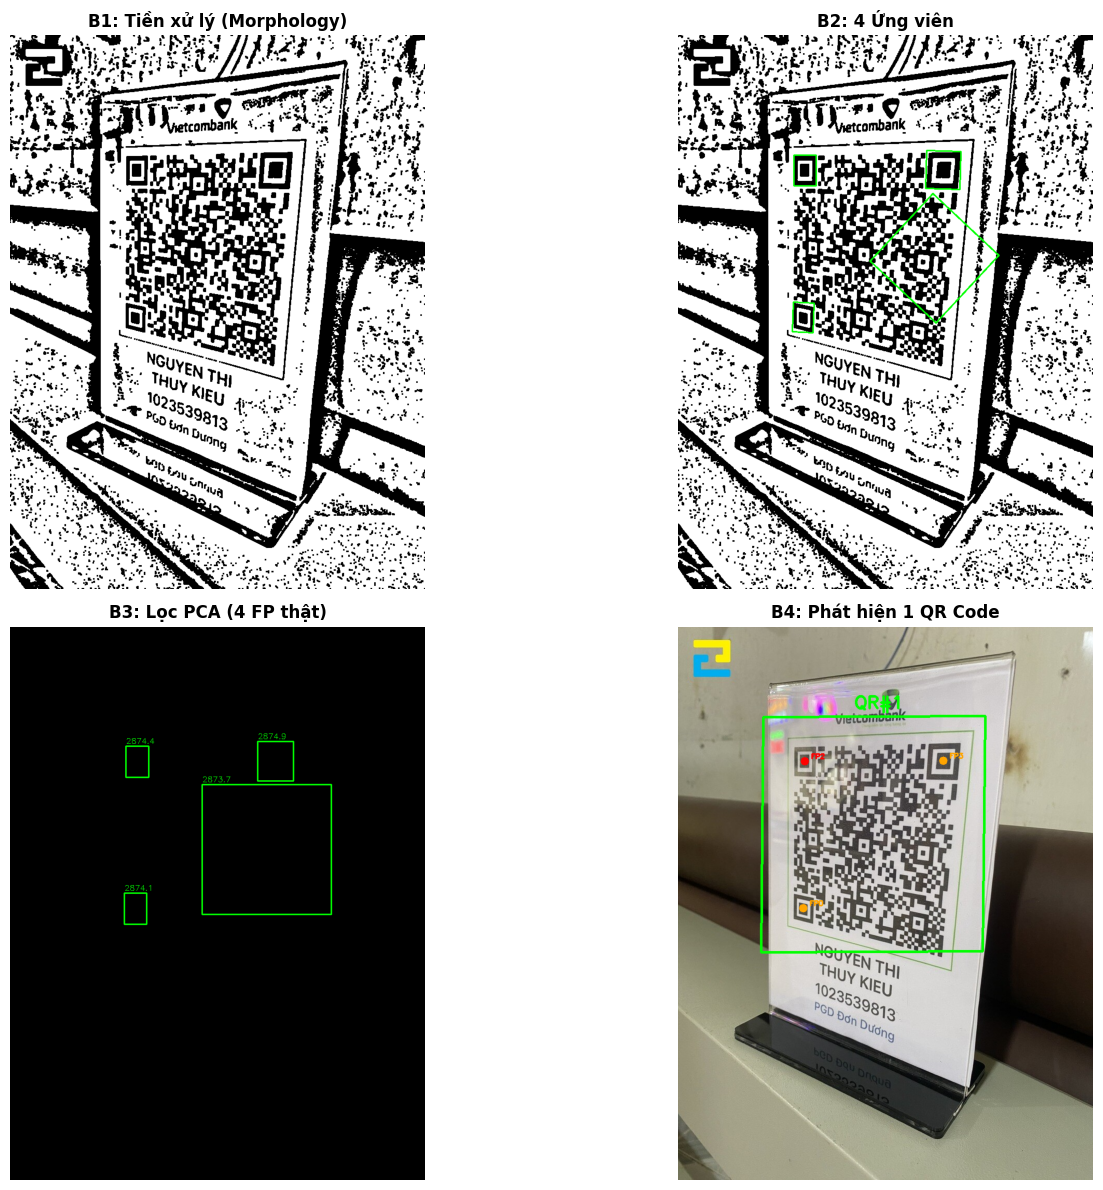

In [22]:
# CHẠY TEST VỚI 1 ẢNH
TARGET_IMAGE = 'QRCode007.jpg'  # Thay bằng tên file ảnh của bạn

def run_single_image_mode(image_path):
    print(f"--- Đang xử lý ảnh đơn: {image_path} ---")

    # 1. Bước 1: Tiền xử lý
    final_binary, debug_imgs_step1 = step1_preprocessing_refined(image_path)
    if final_binary is None:
        print("❌ Không thể đọc ảnh.")
        return

    # 2. Bước 2: Trích xuất ứng viên
    candidate_imgs, candidate_locs, debug_step2 = step2_extract_candidates_pca_friendly(
        final_binary, debug_imgs_step1["Grayscale"]
    )

    # 3. Bước 3: Lọc bằng PCA
    real_fps, real_locs, step3_debug = step3_pca_filter(
        candidate_imgs, candidate_locs, pca_model, final_binary.shape
    )

    # 4. Bước 4: Gom nhóm & Vẽ Bounding Box
    result_image, detected_qr = step4_grouping_and_bbox(
        real_fps, real_locs, debug_imgs_step1["Original"]
    )

    # HIỂN THỊ KẾT QUẢ
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes[0, 0].imshow(final_binary, cmap='gray')
    axes[0, 0].set_title("B1: Tiền xử lý (Morphology)", fontweight='bold')
    
    axes[0, 1].imshow(cv2.cvtColor(debug_step2, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title(f"B2: {len(candidate_imgs)} Ứng viên", fontweight='bold')

    axes[1, 0].imshow(cv2.cvtColor(step3_debug, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title(f"B3: Lọc PCA ({len(real_fps)} FP thật)", fontweight='bold')

    axes[1, 1].imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title(f"B4: Phát hiện {len(detected_qr)} QR Code", fontweight='bold')

    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

run_single_image_mode(TARGET_IMAGE)

### **Chạy nhiều ảnh từ file và Đánh giá kết quả**

In [24]:
def run_batch_evaluation(input_path, output_path, gt_per_image=1):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.JPG')
    image_files = [
        os.path.join(input_path, f) for f in os.listdir(input_path)
        if f.lower().endswith(valid_extensions)
    ]

    if not image_files:
        print(f"⚠️ Không tìm thấy ảnh...")
        return

    print(f"🚀 Bắt đầu Batch Mode: Đang xử lý {len(image_files)} ảnh...\n")

    results_log = []
    total_time = 0
    total_tp = 0  # True Positives
    total_fp = 0  # False Positives
    total_fn = 0  # False Negatives

    for img_path in image_files:
        fname = os.path.basename(img_path)
        start_t = time.time()

        binary, debug = step1_preprocessing_refined(img_path)
        if binary is None: continue

        cand_imgs, cand_locs, _ = step2_extract_candidates_pca_friendly(binary, debug["Grayscale"])
        real_f, real_l, _ = step3_pca_filter(cand_imgs, cand_locs, pca_model, binary.shape)
        result_img, detected = step4_grouping_and_bbox(real_f, real_l, debug["Original"])

        end_t = time.time()
        proc_time = end_t - start_t
        total_time += proc_time

        # Tính toán chỉ số cho từng ảnh
        found_qrs = len(detected)
        tp = min(found_qrs, gt_per_image)
        fp = max(0, found_qrs - gt_per_image)
        fn = max(0, gt_per_image - found_qrs)

        total_tp += tp
        total_fp += fp
        total_fn += fn

        cv2.imwrite(os.path.join(output_path, f"result_{fname}"), result_img)

        results_log.append({
            "File": fname,
            "FPs": len(real_f),
            "QR": found_qrs,
            "Time(s)": round(proc_time, 4),
            "TP": tp, "FP": fp, "FN": fn
        })

    n = float(len(image_files))
    tp = float(total_tp)
    fp = float(total_fp)
    fn = float(total_fn)

    acc_val = (tp / n) * 100 if n > 0 else 0.0
    pre_val = (tp / (tp + fp)) * 100 if (tp + fp) > 0 else 0.0
    rec_val = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0.0
    avg_time = (total_time / n) if n > 0 else 0.0
    speed_fps = (n / total_time) if total_time > 0 else 0.0

    print("\n Bảng đánh giá kết quả:")
    print("📊 Accuracy:  {:.2f}%".format(acc_val))
    print("🎯 Precision: {:.2f}%".format(pre_val))
    print("🔍 Recall:    {:.2f}%".format(rec_val))
    # print("⏱️ Avg Time:  {:.4f} s / image".format(avg_time))
    print("⚡ Speed:     {:.2f} FPS".format(speed_fps))
    return pd.DataFrame(results_log)
    
# Thực thi Batch Mode
df_eval = run_batch_evaluation(INPUT_DIR, OUTPUT_DIR, gt_per_image=1)

# Hiển thị bảng chi tiết (5 hàng đầu)
if df_eval is not None:
    display(df_eval.head())

🚀 Bắt đầu Batch Mode: Đang xử lý 65 ảnh...

[STEP 2] Tìm thấy 3 ứng viên (xoay + méo OK)

 BẮT ĐẦU BƯỚC 3: KIỂM TRA 3 ỨNG VIÊN 
Ứng viên 0: THẬT (Dist: 2876.38 <= 3180.75)
Ứng viên 1: THẬT (Dist: 2877.63 <= 3180.75)
Ứng viên 2: THẬT (Dist: 2876.92 <= 3180.75)
Kết quả: Giữ lại 3/3 ứng viên.

BƯỚC 4: PHÂN TÍCH 3 FINDER PATTERNS
✓ FP[0,1,2] - Góc:FP2 - Q:151

✅ PHÁT HIỆN 1 QR CODE
[STEP 2] Tìm thấy 3 ứng viên (xoay + méo OK)

 BẮT ĐẦU BƯỚC 3: KIỂM TRA 3 ỨNG VIÊN 
Ứng viên 0: THẬT (Dist: 2879.47 <= 3180.75)
Ứng viên 1: THẬT (Dist: 2877.33 <= 3180.75)
Ứng viên 2: THẬT (Dist: 2877.42 <= 3180.75)
Kết quả: Giữ lại 3/3 ứng viên.

BƯỚC 4: PHÂN TÍCH 3 FINDER PATTERNS
✓ FP[0,1,2] - Góc:FP2 - Q:141

✅ PHÁT HIỆN 1 QR CODE
[STEP 2] Tìm thấy 3 ứng viên (xoay + méo OK)

 BẮT ĐẦU BƯỚC 3: KIỂM TRA 3 ỨNG VIÊN 
Ứng viên 0: THẬT (Dist: 2878.09 <= 3180.75)
Ứng viên 1: THẬT (Dist: 2875.57 <= 3180.75)
Ứng viên 2: THẬT (Dist: 2874.72 <= 3180.75)
Kết quả: Giữ lại 3/3 ứng viên.

BƯỚC 4: PHÂN TÍCH 3 FINDER PATTERN

,File,FPs,QR,Time(s),TP,FP,FN
0,QRCode001.jpg,3,1,0.009,1,0,0
1,QRCode002.jpg,3,1,0.013,1,0,0
2,QRCode003.jpg,3,1,0.011,1,0,0
3,QRCode004.jpg,3,1,0.008,1,0,0
4,QRCode005.jpg,3,1,0.008,1,0,0
